# First GNN

**Goal:** Define a GNN to pair jets to form HCs using the same four jets that we're using for the baseline analysis.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import json
import matplotlib.pyplot as plt

import math

# import dgl
# from dgl.data.tree import SST
# from dgl.data import SSTBatch
import networkx as nx

from preprocess import getNumPairs, scale, transformData, prepareData,visualizeInputs
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy

import os
os.sys.path.append('../code')
from analysis import normalizeWeight

%load_ext autoreload
%autoreload 2

Using backend: pytorch


OSError: libcuda.so.1: cannot open shared object file: No such file or directory

## Step 1: Put the 4 anlaysis jets in a pytorch DataLoader object

In [2]:
def build_event_graph(njets=4):
    
    g = dgl.DGLGraph()
    
    # add njets nodes into the graph; nodes are labeled from 0 to njets-1
    g.add_nodes(njets)
    
    # all edges as a list of tuples
    edge_list = [(i,j) for i in range(njets) for j in range(i+1,njets)]
    
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [3]:
G = build_event_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 4 nodes.
We have 12 edges.


Fun fact: I'm going to want to classify based on the *undirected edges*, so my edge classification network will need to operate on both directions of the graph.

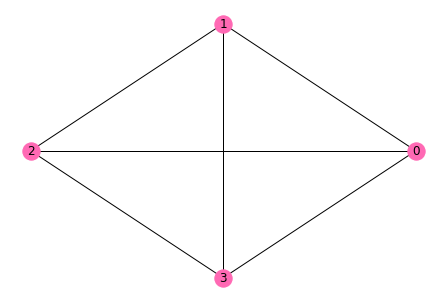

In [4]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=["hotpink"])

In [5]:
G.nodes()

tensor([0, 1, 2, 3])

In [6]:
G.edges()

(tensor([0, 0, 0, 1, 1, 2, 1, 2, 3, 2, 3, 3]),
 tensor([1, 2, 3, 2, 3, 3, 0, 0, 0, 1, 1, 2]))

**Change of plans:** If I just use pytorch, I think the preprocessing + model setup is easier.


Ok, so I spent some time looking at the models with the different attention architectures, etc, and I think for this probelem, I want to the matrix describing the self-attention weights to be symmetric.  I can do this for that additive attention model by adding the query and context vectors (instead of concatenating them), I think this is similar to the idea behind Deep Sets, that we use this sum pooling operation to enforce translation invariance.


For the multiplicative attention, I think I would need to *symmetrize* the query and key matrices (so it's the same step), but for some reason, the additive attention model is easier for me to understand. These two models have the same *theoretical complexity*, but the multiplicative attention trains faster because the matrix multipications are very fast on GPUs, although it doesn't scale as well for large dimension in the key space because the gradients saturate.

I'll just use the additive attention method since easier to understand will be faster to code up + modify when I increase the # of jets + need to apply masking, etc.

## Reprocessing the data

**Plan:** Ok, so I wanted to re-run with a different # of jets, so I added this functionality to `preprocess.py`, and now I'm looking at it. 

In [5]:
reload = True

physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'AUG2019'
    
trigger ='2016_triggers'

fName = "/files/df_f_0.22_00*.h5"

In [4]:
# I don't want all the columns... so just load a few
jetVars = ['pt','eta','phi','E','Db']
loadCols = ['j{}_{}'.format(i,v) for i in range(nSelectedJets) for v in jetVars]
loadCols += ['mc_sf','njets','nbtags','correctPair','selJet_correctPair','eventNumber','runNumber']

I figured that I could concat all the 3b files, and then *later* I can filter on 4b events.

In [8]:
if reload:

    for mc in ['mc16a','mc16d','mc16e']:
    
        subDir = f'{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets'
        print("Processing",subDir)
        
        dfs = []
        for myFile in tqdm(glob('../data/' + subDir + fName)):

            dfi = pd.read_hdf(myFile,key='df')
            loadMask = dfi.fourGoodJets & (dfi.nbtags >= 3) & dfi[trigger]
            dfs.append(dfi.loc[loadMask, loadCols])
            
        df = pd.concat(dfs)

        # Save the df for future use
        df.to_hdf('../data/' + subDir + "/df_f_0.22_3b.h5", key='df',mode='w')
        break
# Load in the mc16a one for the subsequent plots
mc = 'mc16a'
subDir = f'{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets'
df = pd.read_hdf('../data/' + subDir + "/df_f_0.22_3b.h5",key='df')

  0%|          | 0/140 [00:00<?, ?it/s]

Processing SMNR_mc16a_PFlow-AUG2019-5jets


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
 46%|████▋     | 65/140 [01:40<01:47,  1.44s/it]

KeyboardInterrupt: 

In [10]:
for c in dfi.columns:
    print(c)

eventNumber
nresolvedJets
nmuon
passedTriggerHashes
resolvedJets_E
resolvedJets_pt
resolvedJets_phi
resolvedJets_eta
resolvedJets_MV2c10
resolvedJets_is_MV2c10_FixedCutBEff_70
muon_pt
muon_eta
muon_phi
muon_m
muon_EnergyLoss
resolvedJets_SF_MV2c10_FixedCutBEff_70
mcChannelNumber
mcEventWeight
weight_pileup
rand_run_nr
truth_pt
truth_eta
truth_phi
truth_E
truth_pdgId
truth_barcode
truth_child_barcode
truth_parent_barcode
mc_sf
pair0_HC1_m
pair0_HC1_dRjj
pair0_HC1_pt
pair0_HC1_eta
pair0_HC1_phi
pair0_HC2_m
pair0_HC2_dRjj
pair0_HC2_pt
pair0_HC2_eta
pair0_HC2_phi
pair1_HC1_m
pair1_HC1_dRjj
pair1_HC1_pt
pair1_HC1_eta
pair1_HC1_phi
pair1_HC2_m
pair1_HC2_dRjj
pair1_HC2_pt
pair1_HC2_eta
pair1_HC2_phi
pair2_HC1_m
pair2_HC1_dRjj
pair2_HC1_pt
pair2_HC1_eta
pair2_HC1_phi
pair2_HC2_m
pair2_HC2_dRjj
pair2_HC2_pt
pair2_HC2_eta
pair2_HC2_phi
pair0_Dhh
pair1_Dhh
pair2_Dhh
HC1_pt
HC1_eta
HC1_phi
HC1_m
HC1_ntags
HC2_pt
HC2_eta
HC2_phi
HC2_m
HC2_ntags
j0_pt
j0_eta
j0_phi
j0_m
j0_E
j0_idx
j0_jvc
j0_Db
j1_p

Probably for the sanity check plots at the beginning of this nb I might just want to look @ mc16a

In [11]:
df.columns

Index(['j0_pt', 'j0_eta', 'j0_phi', 'j0_E', 'j0_Db', 'j1_pt', 'j1_eta',
       'j1_phi', 'j1_E', 'j1_Db', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_E', 'j2_Db',
       'j3_pt', 'j3_eta', 'j3_phi', 'j3_E', 'j3_Db', 'j4_pt', 'j4_eta',
       'j4_phi', 'j4_E', 'j4_Db', 'mc_sf', 'njets', 'nbtags', 'correctPair',
       'selJet_correctPair', 'eventNumber', 'runNumber'],
      dtype='object')

In [12]:
# This one only has 4 jets - I should make the corresponding one for AUG2019 too
# df_4j = pd.read_hdf("../data/SMNR_PFlow-FEB2019/df_f_0.22.h5",key='df')
# np.sum(df_4j.loc[df_4j.MDR,'mc_sf']) / np.sum(df_4j.loc[df_4j.fourGoodJets,'mc_sf'])

In [13]:
# v4d = ['pt','eta','phi','m']
# X = np.dstack([df[['j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in v4d])
# X.shape

How to keep track of the combinations (thanks @Rafael and @Sean):
- First choose 4 jets out of N jets
- Then combine these 4 jets into 2 pairs

So we can get an expression for the analytical

$${N\choose4} \frac{1}{2} {4\choose2} = \frac{N!}{(N-4)!4!} \cdot 3 = \frac{N(N-1)(N-2)(N-3)}{8}$$


Ok, let's make a plot how this scales w/ the # of jets

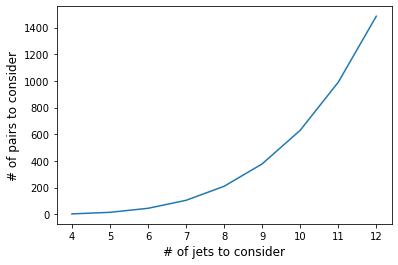

In [14]:
N = np.arange(4,13)
y = [getNumPairs(n) for n in N]

plt.plot(N,y)
plt.xlabel('# of jets to consider',fontsize=12)
plt.ylabel('# of pairs to consider',fontsize=12)

plt.savefig("figures/nCombinations.pdf")

plt.show()

Ok... good to know, this is definitely *not* going to scale to large #s of jets.

This means we might be able to do the dynamic graph CNN :D 

And then this *will be* a graph NN again!!

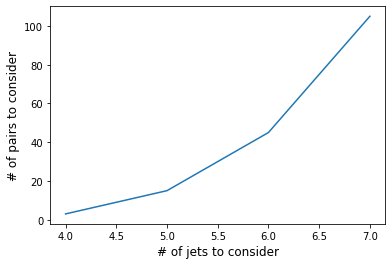

In [15]:
plt.plot(N[:4],y[:4])
plt.xlabel('# of jets to consider',fontsize=12)
plt.ylabel('# of pairs to consider',fontsize=12)
plt.savefig("figures/nCombinations_zoom.pdf")
plt.show()

I might want to do the thing where I put the jets that have the same # of jets in the same batch (to save space).

^ Yeah, this is a really good idea!!

Or... I could write a solution for 6 or 7 jets, and then for cases where I have more than this, I could use the 7 jets in the even that have the highest b-tagging score (I think this is also a reasonable solution, and I can do further truth studies to see how much we might expect to gain from more jets.)

Ok, I also wanted to code up a way to list the iterations w/o these `continue` statements, since this might be a bit cleaner.

In [16]:
i = 1
njets = 5

for i0 in range(njets-3):
    for i1 in range(i0+1,njets-2):
        for i2 in range(i1+1,njets-1):
            for i3 in range(i2+1,njets):
                
                print(f"{i:2d}. ",  (i0,i1),(i2,i3))
                print(f"{i+1:2d}. ",(i0,i2),(i1,i3))
                print(f"{i+2:2d}. ",(i0,i3),(i1,i2))
                
                i += 3

 1.  (0, 1) (2, 3)
 2.  (0, 2) (1, 3)
 3.  (0, 3) (1, 2)
 4.  (0, 1) (2, 4)
 5.  (0, 2) (1, 4)
 6.  (0, 4) (1, 2)
 7.  (0, 1) (3, 4)
 8.  (0, 3) (1, 4)
 9.  (0, 4) (1, 3)
10.  (0, 2) (3, 4)
11.  (0, 3) (2, 4)
12.  (0, 4) (2, 3)
13.  (1, 2) (3, 4)
14.  (1, 3) (2, 4)
15.  (1, 4) (2, 3)


In [17]:
smText = "$\mathbf{ATLAS}$ Simulation Internal\n"
smText += f"SM NR mc16a {prodTag} prod with 2016 triggers\n"
smText += "4 jets $p_T$ > 40 GeV, $|\eta| < 2.5$, 3 b-tagged at MV2c10 70% WP"

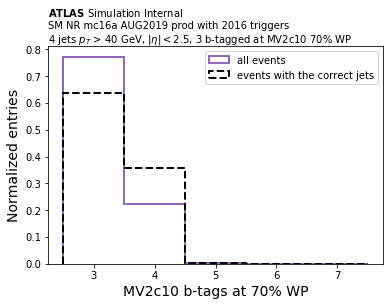

In [18]:
n,_,_ = plt.hist(df.nbtags,5,(2.5,7.5),weights=df.mc_sf/np.sum(df.mc_sf),
                 color='C4',linewidth=2,histtype='step',label='all events')

plt.xlabel("MV2c10 b-tags at 70% WP", fontsize=14)
plt.ylabel("Normalized entries", fontsize=14)

ax = plt.gca()
plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f"figures/{subDir}/nbtags_3b.pdf")

m,_,_ = plt.hist(df.loc[df.correctPair!=-1,'nbtags'],5,(2.5,7.5),
                 weights=df.loc[df.correctPair!=-1,'mc_sf']/np.sum(df.loc[df.correctPair!=-1,'mc_sf']),
                 color='k',linewidth=2,histtype='step',linestyle='--',
                 label='events with the correct jets')
plt.legend()
plt.savefig(f"figures/{subDir}/nbtags_3b_correctJets.pdf")

plt.show()

In [19]:
n

array([7.72670968e-01, 2.23783652e-01, 3.40338107e-03, 1.41998933e-04,
       0.00000000e+00])

In [20]:
m

array([6.36973895e-01, 3.58404103e-01, 4.60502916e-03, 1.69721226e-05,
       0.00000000e+00])

Ok, I *think* we'll probably be fine ignoring the 6 and 7 jet categories.

Ok, so for the `resolvedJets_`, I have E, pt, phi, and eta.

**Question:** For the masked version of the df, how many jets will I need?

In [21]:
np.max(df.nbtags)

6

If I keep the $p_T$ cut the same and don't put *any* cut on the # of b-tags, this will increase a bit.

In [22]:
np.max(df.njets)

12.0

In [23]:
np.sum(df.correctPair.values==-1) / len(df.index)

0.38865949427695684

Ok, yeah, I *think* this is checking out, we're losing these other events b/c of the $p_T$ cut.

Put into the pytorch dataloader, train-test split... and all that jazz!

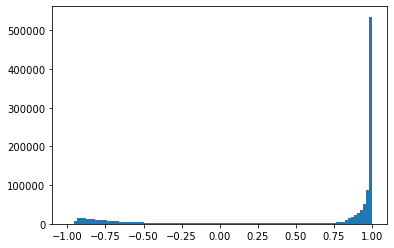

In [25]:
MV2c10 = {60 : 0.94,
          70 : 0.83,
          77 : 0.64,
          85 : 0.11}

discs = df[[f'j{i}_Db' for i in range(nSelectedJets)]].values

edges = [-1,0.11,0.64,0.83,0.94,1]
np.digitize(discs,edges)

plt.hist(discs[discs!=0],100)
plt.show()

Ok, right, this was good to remember that the discriminant for MV2 was between -1 and +1.

(I should prob code it up more generally though so that I don't get confused for when we move to DL1r.)

Scaling pt.
Scaling E.
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16a_PFlow-AUG2019-5jets/df_f_0.22_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16d_PFlow-AUG2019-5jets/df_f_0.22_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16e_PFlow-AUG2019-5jets/df_f_0.22_3b_scaledInputs.h5


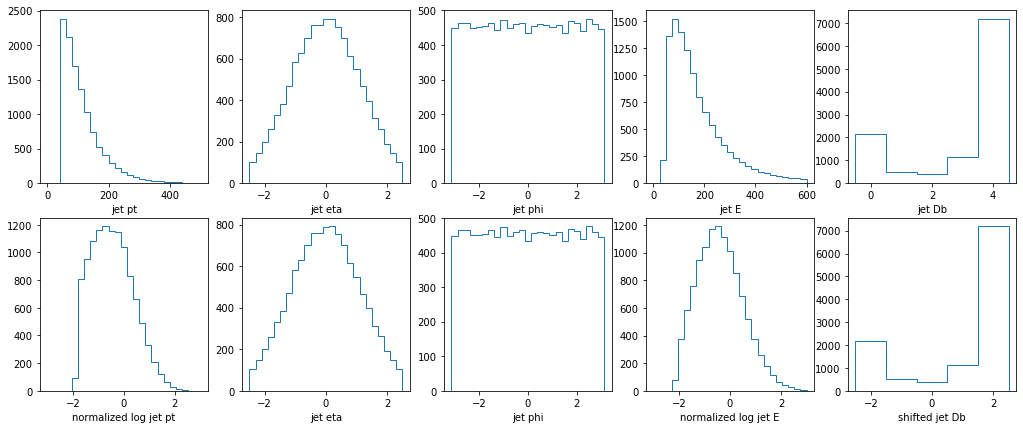

In [26]:
prepareData(nSelectedJets=nSelectedJets)

Ok, this is pretty cool that we actually mostly are $b$-tagged at the 60% WP...

Later I think I might want to think about how to integrate this type of info for defining analysis categories based on b-tagging purity.


In [27]:
256*4

1024

In [3]:
loader_train, loader_val = getGNNDataLoaders(2048,nSelectedJets=nSelectedJets,prodTag=prodTag)

NameError: name 'getGNNDataLoaders' is not defined

## Step 2: Define the architecture

Ok, so as I continued to work through tutorials, it sounded like the architecture that I actually wanted to use since I'm operating on sets is going to be more straightforward to implement in pytorch than DGL.

### GAT in pytorch

From [The Annotated Encoder Decoder](https://bastings.github.io/annotated_encoder_decoder/) tutorial.

From [Attention Seq2Seq with PyTorch: learning to invert a sequence](https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53) Towards Data Science tutorial.

### Transformer in pytorch

**Note:** Pytorch's linear layer does not include an activation, I need to apply that myself!!!

For my first try, I decided to go w/ a transformer instead of a GAT since a hadn't trained a transformer before, and GAT on sets was basically the same thing that I had done for DIPS with attention.

At first I set up the architecutre here, but now after doing a [hyperparameter scan](https://gitlab.cern.ch/hartman/dihiggs4b/blob/master/GraphNN/Hyperparameter-Scan.ipynb), I'm going to use the rest of this nb to evalute on the *test set* the best network from these studies:

**Chosen hyperparameters**
- embed_dim: 20
- ff_dim: 20
- nHeads: 4
- dpt: 0.3
- lr: 0.01


In [29]:
import torch

In [30]:
GNNParams= {'physicsSample': 'SMNR',
            'mc': 'mc16ade',
            'prodTag': 'AUG2019',
            'nSelectedJets': 5,
            'nLayers': 1,
            'embed_dim': 20, 
            'ff_dim': 20,
            'nHeads': 4,
            'dpt': 0.3,
            'lr': 0.01,
            'epoch': 19}

nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']

# Load in the model
model = pairAGraph(inpt_dim=len(jetVars),embed_dim=embed_dim,ff_dim=ff_dim,
                   nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)

params = sum([np.prod(p.size()) for p in model.parameters()])
params

AttributeError: module 'torch.nn' has no attribute 'TransformerEncoderLayer'

**Note:** It's probably a good idea to "sanity check" these numbers for the # of hyperparameters to make sure I understand the architecture...

In [ ]:
nSelectedJets

## Step 3: Train the model


Since pytorch doesn't support sample_weights rn, I made a [custom loss function](https://gitlab.cern.ch/hartman/dihiggs4b/blob/master/GraphNN/trainNet.py#L172-179) to
support the weighted events for the NR signal.

Note, if I train on the scalar samples I won't need this, but I think it's still useful for comparison studies for training on scalars versus the SM mc events.


In [ ]:
check_accuracy(loader_train,model)

It's interesting to me that this is closer to $\frac{1}{3}$, the # of pairs with 4 jets than $\frac{1}{15} \approx 0.067$ or the # of valid pairs with 5 jets, which is what I would expected from random guessing out of the 15 valid pairs with 5 jets.

In [ ]:
check_accuracy(loader_train,model,njets=4)

In [ ]:
check_accuracy(loader_train,model,njets=5)

This is almost 2x as accurate as I was expecting lol... maybe my initial state isn't really random?

Load in the weights for this "best model" that I've trained so far.

In [ ]:
modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_lr{lr}_batch2048"
model.load_state_dict(torch.load(f'{modelDir}/model_epoch{epoch}.pt'))
model.eval()

In [ ]:
check_accuracy(loader_train,model,njets=4)

In [ ]:
check_accuracy(loader_train,model,njets=5)

Note: when I combined the stats between the mc campaigns, it really helped the noisiness of the validation loss!

Ok, so my 4b validation accuracy is *close* to 90%, it looks like I *could* keep tuning hyperparameters, etc, but I might focus on cleaning up the rest of the notebook first, and then I can come back and do a dedicated hyperparameter scan.

Ok, so this is *super* interesting, I'm doing better on 3b than 4b, when I don't pass the PC bin information (probably b/c of the prior over the classes), but when I add in the PC bins, I do a lot better w/ 4b!

I was curious if I was overfitting or if I should add some extra regularization techniques, so I looked at the weights of the trained model. Since they seem to have a reasonable range without adding an L2 regularization, I haven't looked into adding one in (yet).

In [ ]:
ws = []
for l in model.parameters():
    ws.append(l.cpu().detach().numpy().reshape(-1))

In [ ]:
modelDir[6:]

In [ ]:
plt.hist(np.concatenate(ws),100)
plt.xlabel('pairAGraph weights',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.savefig(f'figures/{modelDir[6:]}/weights.pdf')
plt.show()

Ok, so for the test set, I reserved the events with *even* event number!

In [ ]:
#device = 'cuda:9' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [1]:
df = pd.read_hdf(f"../data/{subDir}/df_f_0.22_3b_scaledInputs.h5", key='df')
df = df[df.index % 2 == 0]

# Since I'm only using half the stats for the test set, need to multiply L by 2.
L = 24.5556
key = subDir[:-6]
print(key)
normalizeWeight(df,key,lumi=L*2)

NameError: name 'pd' is not defined

In [ ]:
from analysis import fileDir

In [ ]:
fileDir[key]

In [ ]:
model.to(device)
model.eval()

logits, edgeWeights = model(X_test)

logits[~scoreMask] = float('-inf') # 0
_, y_pred = torch.max(logits,1)

y_pred = y_pred.cpu().numpy()
edgeWeights = edgeWeights.cpu().detach().numpy()

**Goal:** Compare the accuracy between 3b and 4b data

In [ ]:
correct = (y_pred == df.correctPair)
acc = np.sum(df.loc[correct,'mc_sf']) / np.sum(df['mc_sf'])
#acc = check_accuracy(loader_test,model,btag=btag)
print(acc)

In [ ]:
for btag in [3,4]:
    m = (df.nbtags == btag)
    acc = np.sum(df.loc[correct & m,'mc_sf']) / np.sum(df.loc[m,'mc_sf'])
    print(f"{btag}b",acc)

**Yikes!** This seems like *horrible* generalization ;(

I feel like this has to be wrong, b/c I was getting good results on the test set before.


Oh, or maybe this is b/c before I was calculating #s w/.r.t the valid pairs

In [ ]:
valid = (df.correctPair != -1)

print('Accuracy for events with a valid pair')
acc = np.sum(df.loc[correct & valid,'mc_sf']) / np.sum(df.loc[valid,'mc_sf'])
print(acc)

for btag in [3,4]:
    m = (df.nbtags == btag)
    acc = np.sum(df.loc[correct & m & valid,'mc_sf']) / np.sum(df.loc[m & valid,'mc_sf'])
    print(f"{btag}b",acc)

## Visualizations

**Goal:** I kind of just wanted to visualize the attention weights on the test set as a "sanity check" that my method was working.


In [ ]:
def eventGraph(edgeWeights, y_pred, njets, yi, subDir='', ievt=-1,verbose=False):
    '''
    Goal: given an event number, visualize the attention weights corresponding
    to the paired Higgses.
    
    Inputs:
    - edgeWeights
    - y_pred
    - njets:
    - yi:
    - subDir
    - ievt
    '''
    
    nx_G = nx.Graph()
    nx_G.add_nodes_from(range(njets))
    edge_list = [(i,j) for i in range(njets) for j in range(i+1,njets)]
    nx_G.add_edges_from(edge_list)
    
    edge_colors = [0.5 * (edgeWeights[i,j] + edgeWeights[j,i])  
                   for i,j in nx_G.edges]
    
    # Get the truth edges
    k = 0
    truthEdges = {}
    for i0 in range(njets-3):
        for i1 in range(i0+1,njets-2):
            for i2 in range(i1+1,njets-1):
                for i3 in range(i2+1,njets):

                    truthEdges[k]   = [(i,j) for i,j in nx_G.edges() 
                                       if (i==i0 and j==i1) or (i==i2 and j ==i3)]
                    truthEdges[k+1] = [(i,j) for i,j in nx_G.edges() 
                                       if (i==i0 and j==i2) or (i==i1 and j ==i3)]
                    truthEdges[k+2] = [(i,j)  for i,j in nx_G.edges() 
                                       if (i==i0 and j==i3) or (i==i1 and j ==i2)]
                    k += 3
    
    '''
    Draw the graph
    '''  
    plt.figure()
    
    pos = nx.kamada_kawai_layout(nx_G)
    if verbose:
        print(nx_G.edges)
        print(edge_colors)
        print("truth pair:",truthEdges[yi])
        print("predicted pair:",truthEdges[y_pred])
        
    nx.draw(nx_G, pos, with_labels=True, node_color=["lightskyblue"], edge_cmap=plt.cm.Greys,
            edge_color=edge_colors,edge_vmin=0,edge_vmax=1.5*np.max(edge_colors),style='-',width=7)

    # Make a new graph w/ just the true connections
    t = nx.Graph()
    t.add_nodes_from(range(njets))
    t.add_edges_from(truthEdges[yi])
    
    nx.draw_networkx_edges(t, pos, edgelist=t.edges, edge_color='red', 
                           edge_vmin=0,edge_vmax=1,style='--',width=2)
        
    title = 'Correct pair chosen' if y_pred == yi else 'Incorrect pair chosen'
    plt.title(title,loc='left')
        
    # Save the figure
    if len(subDir) != 0:
        plt.savefig(f'figures/{subDir}/graph_{njets}jets_{ievt}.pdf',bbox_inches='tight')
        
    plt.show()

**What do I actually need to pass to this function?**
- The edgeWeights
- The number of jets
- The true labels
- If I want to save the graph, I should pass a subdirectory and event # to save
  each figure to a unique place
- Maybe some text to put in the upper right hand corner(?)

In [ ]:
subDir

In [ ]:
for ievt, ei, pred, ni, yi in zip(range(100), edgeWeights, y_pred, njets, df.correctPair.values):
    print(edgeWeights)
    
    break
    if yi == -1:
        continue
        
    eventGraph(ei, pred, ni, yi, subDir+"/graphViz", ievt,verbose=True)
    #break                      

Ok, so it seems pretty clear to me that the model has successfully trained :)

**Idea:** It *might* also be fun to add the node colored by which b-tagging bin we're in with the transparency indicating the $p_T$ of the jet.

## Step 4: Compare results

**Question:** How often does it put the same jet in two separate HCs?


**Recall:** The baseline model was $\approx$ 90% accurate. 

It would probably also be useful to look at the accuratcy in $m_{4j}$ bins.

**Other visualizations:**
- Weights of the attention layer
- Entropy (for signal and background, or events that only had 3 of the HC jets?)
- TSNE plot

**Conclusions / Next steps:**

- Code up the application for varying #s of pairs in the event for varying numbers of jets 


## Step 5: Get $m_{hh}$ histograms and compare the limits

In [ ]:
from preprocess import getHCs, applyCuts, getHelicityAngles
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

In [ ]:
# HCa, HCb, ja0, ja1, jb0, jb1 = getHCs(df,model,nSelectedJets)
# getHelicityAngles(df, HCa, HCb, ja0, ja1, jb0, jb1, (ja0.pt + ja1.pt) > (jb0.pt + jb1.pt))

In [ ]:
applyCuts(df,model,nSelectedJets)

In [ ]:
df.columns

In [ ]:
subDir

So that my histograms are comparable with the ones that I'm getting from `resolved-recon`, I'm going to need to do the correct scaling.

In [ ]:
df.columns

In [ ]:
j0 = TLorentzVectorArray.from_ptetaphi( *[df.loc[df.nbtags>=4,f'j0_{v}'] for v in jetVars[:4]] )
j1 = TLorentzVectorArray.from_ptetaphi( *[df.loc[df.nbtags>=4,f'j1_{v}'] for v in jetVars[:4]] )
j2 = TLorentzVectorArray.from_ptetaphi( *[df.loc[df.nbtags>=4,f'j2_{v}'] for v in jetVars[:4]] )
j3 = TLorentzVectorArray.from_ptetaphi( *[df.loc[df.nbtags>=4,f'j3_{v}'] for v in jetVars[:4]] )

m4j_baseline = (j0+j1+j2+j3).mass

In [ ]:
m4j = df.m_hh

In [ ]:
for density,ylabel in zip([False,True],['Entries','Normalized Entries']):
    plt.figure()
    plt.hist(m4j,100,(0,1250),histtype='step',label='4 jets selected by GNN',
             weights=df.mc_sf,color='darkorange',density=density)
    plt.hist(m4j_baseline,100,(0,1250),histtype='step',color='magenta',label='4 b-jets from baseline',
             weights=df.loc[df.nbtags>=4,'mc_sf'],density=density)
    
    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.legend(fontsize=12)
    
    ax = plt.gca()
    plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    
    plt.show()

Also, I think it would be interesting to compare the baseine 4b jets to the jets selected by the GNN for the 4b category.

Intuitively I was hoping the GNN would be doing the same thing.

In [ ]:
fourbText = "$\mathbf{ATLAS}$ Simulation Internal\n"
fourbText += "SM NR mc16a with 2016 triggers\n"
fourbText += "4 b-jets $p_T$ > 40 GeV, $|\eta| < 2.5$"

In [ ]:
for density,ylabel,tag in zip([False,True],['Entries','Normalized Entries'],['','_norm']):
    
    plt.figure()

    plt.hist(m4j[df.nbtags>=4],50,(0,1250),histtype='step',label='4 GNN jets in 4b evts',
             weights=df.loc[df.nbtags>=4,'mc_sf'],color='purple',density=density)

    plt.hist(m4j_baseline,50,(0,1250),histtype='step',color='magenta',label='4 b-jets from baseline',
             weights=df.loc[df.nbtags>=4,'mc_sf'],density=density)

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.legend(fontsize=12)

    ax = plt.gca()
    plt.text(0,1,fourbText,ha='left',va='bottom',transform=ax.transAxes)
    plt.savefig(f'figures/{subDir}/m4j_4b_cf_baseline{tag}.pdf')
    plt.show()

Ok, this is encouraging, at this point, the two algorithms are basically doing the same thing!

**MDR**

In [ ]:
# For this cut, the HCs are ordered by the scalar sum of the jet pTs
lead_dR, subl_dR = df.dRjj_h1, df.dRjj_h2

Ok, so I might need to rewrite this function for operating on arrays (nbd)

**Visualize these cuts**

Note: This MDR cur is simpler than how I was visualizing it before, because before I was looking at all the possible pairs, and now I already have the pair defined!

In [ ]:
m4j_min, m4j_max = 1, 1250 # GeV
ms = np.linspace(m4j_min, m4j_max) 

Rmin_lead = 360 / ms - 0.5
Rmax_lead = 653 / ms + 0.475

Rmin_subl = 235 / ms
Rmax_subl = 875 / ms + 0.35

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(8,12))

masks = [np.ones_like(m4j).astype(bool),(df.nbtags==4),(df.nbtags==3)]

for axs,cmap,mask,text in zip(axes,['Oranges','Purples','Reds'],masks,['all','4b','3b']):
    
    for ax,dRjj,Rmin,Rmax,c in zip(axs,[lead_dR,subl_dR],[Rmin_lead,Rmin_subl],
                                   [Rmax_lead,Rmax_subl],['rebeccapurple','navy']):
    
        # Make the plot
        ax.hist2d(m4j[mask],dRjj[mask],bins=25,range=[(0,1100),(0,4)],cmap=cmap,
                      weights=df.loc[mask,'mc_sf'])
        #plt.colorbar(img,cax=axs[0])

        # Overlay the cuts
        ax.plot(ms,Rmin, c)
        ax.plot(ms,Rmax, c)

        ax.text(.95,.95,text,va='top',ha='right',transform=ax.transAxes,fontsize=12)
        
# Add legends
for i in range(3):
    axes[i,0].set_ylabel('$\Delta R_{jj}$',fontsize=14)    
for j,HC in enumerate(['Leading','Subleading']):
    axes[-1,j].set_xlabel('$m_{4j}$ [GeV]',fontsize=14)
    axes[0,j].set_title(f'{HC} HC (sum of jet $p_T$s)')

plt.savefig(f'figures/{subDir}/dRjj_vs_m4j_3+4b.pdf')    

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(8,12))

masks = [m & (df.correctPair != -1) for m in [np.ones_like(m4j).astype(bool),(df.nbtags==4),(df.nbtags==3)]]

for axs,cmap,mask,text in zip(axes,['Oranges','Purples','Reds'],masks,['all','4b','3b']):
    
    for ax,dRjj,Rmin,Rmax,c in zip(axs,[lead_dR,subl_dR],[Rmin_lead,Rmin_subl],
                                   [Rmax_lead,Rmax_subl],['rebeccapurple','navy']):
    
        # Make the plot
        ax.hist2d(m4j[mask],dRjj[mask],bins=25,range=[(0,1100),(0,4)],cmap=cmap,
                      weights=df.loc[mask,'mc_sf'])

        # Overlay the cuts
        ax.plot(ms,Rmin, c)
        ax.plot(ms,Rmax, c)

        ax.text(.95,.95,text+": correct pair $\exists$",
                va='top',ha='right',transform=ax.transAxes,fontsize=12)
        
    
# Add legends
for i in range(3):
    axes[i,0].set_ylabel('$\Delta R_{jj}$',fontsize=14)    
for j,HC in enumerate(['Leading','Subleading']):
    axes[-1,j].set_xlabel('$m_{4j}$ [GeV]',fontsize=14)
    axes[0,j].set_title(f'{HC} HC (sum of jet $p_T$s)')
    
plt.savefig(f'figures/{subDir}/dRjj_vs_m4j_3+4b_correctPairExists.pdf') 

In [ ]:
np.sum(df.loc[df.correctPair!=-1,'mc_sf'])/np.sum(df.mc_sf)

Ok, the biggest difference between these plots and the one above seems to be in the "all" and the 3b cateogries.

Now this is more than 50% of the events that have the correct pair, does this make sense?

I should probably tabulate some of these numbers.

**Just looking at events where I got the correct pair**

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(8,12))

masks = [m & (df.correctPair == y_pred) for m in [np.ones_like(m4j).astype(bool),(df.nbtags==4),(df.nbtags==3)]]

for axs,cmap,mask,text in zip(axes,['Oranges','Purples','Reds'],masks,['all','4b','3b']):
    
    for ax,dRjj,Rmin,Rmax,c in zip(axs,[lead_dR,subl_dR],[Rmin_lead,Rmin_subl],
                                   [Rmax_lead,Rmax_subl],['rebeccapurple','navy']):
    
        # Make the plot
        ax.hist2d(m4j[mask],dRjj[mask],bins=25,range=[(0,1100),(0,4)],cmap=cmap,
                      weights=df.loc[mask,'mc_sf'])

        # Overlay the cuts
        ax.plot(ms,Rmin, c)
        ax.plot(ms,Rmax, c)

        ax.text(.95,.95,text+": pairAGraph correct",
                va='top',ha='right',transform=ax.transAxes,fontsize=12)
    
# Add legends
for i in range(3):
    axes[i,0].set_ylabel('$\Delta R_{jj}$',fontsize=14)    
for j,HC in enumerate(['Leading','Subleading']):
    axes[-1,j].set_xlabel('$m_{4j}$ [GeV]',fontsize=14)
    axes[0,j].set_title(f'{HC} HC (sum of jet $p_T$s)')
    
plt.savefig(f'figures/{subDir}/dRjj_vs_m4j_3+4b_correctPair.pdf') 

In [ ]:
for tag, mask in zip(['all','4b','3b'],[np.ones_like(m4j).astype(bool),(df.nbtags==4),(df.nbtags==3)]):
    
    print(tag,np.sum(df.loc[df.MDR & mask,'mc_sf'])/np.sum(df.loc[mask,'mc_sf']))
    

Ok, so this is *also* encouraging, it looks like the same # of events are passing MDR with the GNN pairing as with the baseline.

I *think* it might also be worth sanity checking this at this point...

So 65% of these events are passing the MDR cuts.

**Plans:** Let's remake the $m_{4j}$ plot, and maybe I can come back to this to try to understand *why*.

In [ ]:
for density,ylabel in zip([False,True],['Entries','Normalized Entries']):
    plt.figure()
    plt.hist(m4j,100,(0,1250),histtype='step',label='4 jets from GNN',
         weights=df.mc_sf,color='darkorange',density=density)
    plt.hist(df.loc[df.MDR,'m_hh'],100,(0,1250),histtype='step',label='MDR',
             weights=df.loc[df.MDR,'mc_sf'],color='cornflowerblue',density=density)

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.legend(fontsize=12)
    
    ax = plt.gca()
    plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    
    plt.show()

Ok, so what this is saying is that I'm mostly loosing the high $m_{4j}$ events, which (I think) is promising from the point of a $\kappa_\lambda$ scan, but maybe not optimal from the point-of-view of setting a SM NR limit.

**MDpT**

Ok, so for the mass dependent $p_T$ cut, the HCs are ordered by the HC $p_T$ now.

Should I visualize this $p_T$ cut as well?

In [ ]:
density=False
ylabel='Entries'

plt.hist(m4j,100,(0,1250),histtype='step',label='4 jets from GNN',
         weights=df.mc_sf,color='darkorange',density=density)
plt.hist(df.loc[df.MDR,'m_hh'],100,(0,1250),histtype='step',label='MDR',
         weights=df.loc[df.MDR,'mc_sf'],color='cornflowerblue',density=density)
plt.hist(df.loc[df.MDR & df.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
         weights=df.loc[df.MDR & df.MDpT,'mc_sf'],color='green',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

plt.show()


Ok, this cut isn't eliminating anything (same story that we saw w/ the baseline analysis).


**Oh, Michael is prob going to want me to make these ratios!!**

**$\Delta \eta_{hh}$**

Ok, so Michael said the lesson from my $\Delta \eta$ categorization was that we probably want to take this cut *out*, but I'll leave it in for now so that I can compare more easily to Todd's results :)


In [ ]:
plt.hist(m4j,100,(0,1250),histtype='step',label='4 jets from GNN',
         weights=df.mc_sf,color='darkorange',density=density)
plt.hist(df.loc[df.MDR,'m_hh'],100,(0,1250),histtype='step',label='MDR',
         weights=df.loc[df.MDR,'mc_sf'],color='cornflowerblue',density=density)
plt.hist(df.loc[df.MDR & df.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
         weights=df.loc[df.MDR & df.MDpT,'mc_sf'],color='green',density=density)
plt.hist(df.loc[df.MDR & df.MDpT & df.cut_deta_hh,'m_hh'],100,(0,1250),histtype='step',label='$|\Delta \eta_{hh}|$  < 1.5',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh,'mc_sf'],color='red',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

plt.show()

**$X_{wt}$**

Need to recalculate it!!

It seems like here we have an option to either loop over the 4 HC jets, or all 5 of the jets that we *considered* for the HC jets.

I *think* to be consistent w/ the baseline anlaysis, I should start by just looping over the 4 HC jets, but it might be interesting to c.f. the distributions if I loop over all of them as well.


In [ ]:
plt.hist(m4j,100,(0,1250),histtype='step',label='4 jets from GNN',
         weights=df.mc_sf,color='darkorange',density=density)
plt.hist(df.loc[df.MDR,'m_hh'],100,(0,1250),histtype='step',label='MDR',
         weights=df.loc[df.MDR,'mc_sf'],color='cornflowerblue',density=density)
plt.hist(df.loc[df.MDR & df.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
         weights=df.loc[df.MDR & df.MDpT,'mc_sf'],color='green',density=density)
plt.hist(df.loc[df.MDR & df.MDpT & df.cut_deta_hh,'m_hh'],100,(0,1250),histtype='step',label='$|\Delta \eta_{hh}|$  < 1.5',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh,'mc_sf'],color='red',density=density)
plt.hist(df.loc[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt,'m_hh'],100,(0,1250),histtype='step',label='$X_{wt}$ > 1.5',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt,'mc_sf'],color='navy',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

plt.show()


Ok, it looks like $X_{wt}$ is preferentially removing some of the low $m{4j}$ events, and I think we saw that this cut might be leading to some sculpting issues as well later, so I *think* it might be worthwhile to revise this later, although it looks like the MDR cut is the biggest deal to look into rn.

**$X_{hh}$**

In [ ]:
plt.hist(m4j,100,(0,1250),histtype='step',label='4 jets from GNN',
         weights=df.mc_sf,color='darkorange',density=density)
plt.hist(df.loc[df.MDR,'m_hh'],100,(0,1250),histtype='step',label='MDR',
         weights=df.loc[df.MDR,'mc_sf'],color='cornflowerblue',density=density)
plt.hist(df.loc[df.MDR & df.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
         weights=df.loc[df.MDR & df.MDpT,'mc_sf'],color='green',density=density)
plt.hist(df.loc[df.MDR & df.MDpT & df.cut_deta_hh,'m_hh'],100,(0,1250),histtype='step',label='$|\Delta \eta_{hh}|$  < 1.5',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh,'mc_sf'],color='red',density=density)
plt.hist(df.loc[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt,'m_hh'],100,(0,1250),histtype='step',label='$X_{wt}$ > 1.5',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt,'mc_sf'],color='navy',density=density)
plt.hist(df.loc[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt & (df.kinematic_region==0),'m_hh'],100,(0,1250),histtype='step',label='$X_{hh}$ < 1.6',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt & (df.kinematic_region==0),'mc_sf'],color='C4',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

plt.show()


In [ ]:
density=False
ylabel='Entries'

nBins = 50

plt.hist(m4j[df.nbtags>=4],100,(0,1250),histtype='step',label='4 jets from GNN',
         weights=df.loc[df.nbtags>=4,'mc_sf'],color='darkorange',density=density)
plt.hist(df.loc[(df.nbtags>=4) & df.MDR,'m_hh'],100,(0,1250),histtype='step',label='MDR',
         weights=df.loc[(df.nbtags>=4) & df.MDR,'mc_sf'],color='cornflowerblue',density=density)
plt.hist(df.loc[(df.nbtags>=4) & df.MDR & df.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
         weights=df.loc[(df.nbtags>=4) & df.MDR & df.MDpT,'mc_sf'],color='green',density=density)
plt.hist(df.loc[(df.nbtags>=4) & df.MDR & df.MDpT & df.cut_deta_hh,'m_hh'],100,(0,1250),histtype='step',label='$|\Delta \eta_{hh}|$  < 1.5',
         weights=df.loc[(df.nbtags>=4) & df.MDR & df.MDpT & df.cut_deta_hh,'mc_sf'],color='red',density=density)
plt.hist(df.loc[(df.nbtags>=4) & df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt,'m_hh'],100,(0,1250),histtype='step',label='$X_{wt}$ > 1.5',
         weights=df.loc[(df.nbtags>=4) & df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt,'mc_sf'],color='navy',density=density)
plt.hist(df.loc[(df.nbtags>=4) & df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt & (df.kinematic_region==0),'m_hh'],100,(0,1250),histtype='step',label='$X_{hh}$ < 1.6',
         weights=df.loc[(df.nbtags>=4) & df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt & (df.kinematic_region==0),'mc_sf'],color='C4',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.legend(fontsize=11)

ax = plt.gca()
plt.text(0,1,fourbText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{subDir}/m4j_allCuts.pdf')

plt.show()



Note, I was seeing a large drop when I applied the $X_{hh}$ cut before.

It might be nice to visualize the mass plane to understand how conservative the current $X_{hh}$ cut is.


In [ ]:
plt.hist(m4j[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt &  (df.kinematic_region==0) & (df.nbtags>=4)],50,(0,1250),histtype='step',label='4b: after $X_{hh}$',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh &df.cut_Xwt &  (df.kinematic_region==0) & (df.nbtags>=4),'mc_sf'],color='C4',density=density)
plt.hist(m4j[df.MDR & df.MDpT & df.cut_deta_hh & df.cut_Xwt&  (df.kinematic_region==0) & (df.nbtags==3)],50,(0,1250),histtype='step',label='3b: after $X_{hh}$',
         weights=df.loc[df.MDR & df.MDpT & df.cut_deta_hh &df.cut_Xwt & (df.kinematic_region==0) & (df.nbtags==3),'mc_sf'],color='C6',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

plt.show()


In [ ]:
for nbtags in [3,4]:
    print(f'{nbtags}b: s =',np.sum(df.loc[df.cut_Xwt & (df.kinematic_region==0) & (df.nbtags==nbtags),'mc_sf']))

Ok, this is still more than an order of magnitude more 4b events than I was expecting.

I don't think this makes sense because for 4b events, 80% of the time we got the right 4-jets, so then I think I should only expect a (maximally) 20% imporvement in the limits from extending the definition of 4-jets.

Probably the *first* order of business is to compare some more of the distributions that I'm cutting on to see how they compare to the 4b analysis, and then maybe the $2^{nd}$ order is to double check my preprocessing code for these two frameworks (with the baseline analysis) because I have probably introduced a bug.

Draw the massplane!

In [ ]:
df.columns

Oh, and remember, what we care about *ultimately* is whether the GNN is *sculpting* the background.

In [ ]:
# base_masks = [df_4j.fourGoodJets, df_4j.MDR, 
#               df_4j.MDpT, df_4j.cut_deta_hh,
#               df_4j.cut_Xwt, df_4j.cut_Xhh]


# counts = np.array([np.sum(df_4j.loc[mask,'mc_sf']) for mask in base_masks])
# unWeighted = [np.sum(df_4j.loc[mask,'mc_sf']) for mask in base_masks]

# x = ['4 b-jets $p_T > 40$ GeV, $|\eta| < 2.5$',
#      'MD $\Delta R_{jj}$', 'MD $p_T(h)$s',
#      '$|\Delta \eta_{hh}| < 1.5$','$X_{wt} > 1.5$',
#      '$X_{hh}$ < 1.6']

In [ ]:
# plt.figure()
# doLog = ('data' in subDir)
# plt.bar(x,counts,width=1,alpha=0.5,color='C4',log=doLog)
# plt.xticks(x,x,rotation=80,fontsize=12)
# plt.ylabel('Acceptance x Efficiency')
# #plt.title(title)
# #plt.savefig('{}/weighted_cutflow.pdf'.format(figDir),bbox_inches='tight')
# plt.show()

Save the df for future use

In [ ]:
df.to_hdf(f"../data/{subDir}/test_df_f_0.22_3b_scaledInputs_withCuts.h5", key='df', mode='w')